In [1]:
import networkx as nx
import numpy as np
import pandas as pd
from sensors import *

In [ ]:
class FlowNetwork:
    def __init__(self, G, flow):
        self.G = G
        self.f = dict2vect(G, flow)
        
    def 

In [2]:
def read_tntp_graph(filename):
    edgelist = pd.read_csv(filename, sep="\t")
    G = nx.from_pandas_edgelist(edgelist, source="From ", target="To ", edge_attr="Volume ",
                           create_using=nx.DiGraph)
    labeled_flows = {(u,v) : d["Volume "] for u,v,d in G.edges(data=True)}
    return G, labeled_flows

In [3]:
flows = {}

Anaheim, flows["Anaheim"] = read_tntp_graph("data/Anaheim/Anaheim_flow.tntp")
Barcelona, flows["Barcelona"] = read_tntp_graph("data/Barcelona/Barcelona_flow.tntp")
Chicago, flows["Chicago"] = read_tntp_graph("data/Chicago-Sketch/ChicagoSketch_flow.tntp")
Winnipeg, flows["Winnipeg"] = read_tntp_graph("data/Winnipeg/Winnipeg_flow.tntp")

In [4]:
def al_flows_greedy(G, labeled_edges, ratio=1, lam=0.01):
    return choose_sensors(G, labeled_edges, predict=flow_prediction, evaluate=mse, 
                          k=int(ratio * G.number_of_edges()), lazy=True, cores=8, debug=False)

sensors = al_flows_greedy(Anaheim, flows["Anaheim"])

  0%|          | 0/914 [00:00<?, ?it/s]

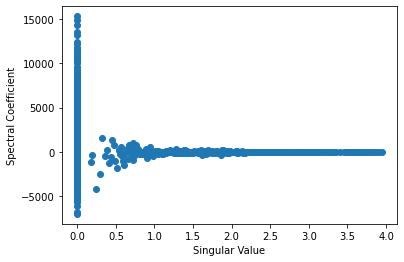

In [5]:
import matplotlib.pyplot as plt

def plot_spectral_coefs(G, flow):
    n, m = G.number_of_nodes(), G.number_of_edges()

    B = nx.incidence_matrix(G, oriented=True).toarray()
    U, s, Vh = scipy.linalg.svd(B)
    Sigma = scipy.linalg.diagsvd(s, U.shape[1], Vh.shape[0])

    plt.scatter(list(s) + [0] * (m - n), Vh @ dict2vect(G, flow))
    plt.xlabel("Singular Value")
    plt.ylabel("Spectral Coefficient")
    
pred = flow_prediction(Anaheim, {s: flows["Anaheim"][s] for s in sensors[:90]})
plot_spectral_coefs(Anaheim, pred)

In [7]:
def cycle_ranks(G, sensors):
    n, m = G.number_of_nodes(), G.number_of_edges()
    B = nx.incidence_matrix(G, oriented=True).toarray()
    U, s, Vh = scipy.linalg.svd(B)
    Sigma = scipy.linalg.diagsvd(s, U.shape[1], Vh.shape[0])
    
    S = [list(G.edges()).index(s) for s in sensors]
    ranks = np.zeros(len(S))
    for i in range(1, len(S)):
        ranks[i] = np.linalg.matrix_rank(Vh.transpose()[np.ix_(S[:i], range(n - 1, m))])
        
    return ranks

In [8]:
sensors_rrqr = al_flows_rrqr(Anaheim, 1)
sensors_rb = al_flows_rb(Anaheim, 1)

In [9]:
rrqr_ranks = cycle_ranks(Anaheim, sensors_rrqr)
rb_ranks = cycle_ranks(Anaheim, sensors_rb)
greedy_ranks = cycle_ranks(Anaheim, sensors)

Text(0, 0.5, 'Dimension of Cycle Space')

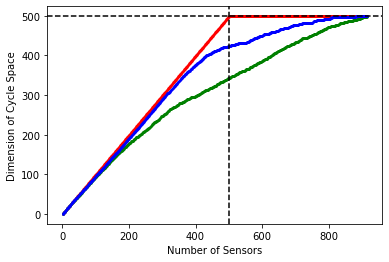

In [10]:
for ranks, c in zip([rrqr_ranks, rb_ranks, greedy_ranks], ["r", "g", "b"]):
    plt.scatter(range(1, len(ranks)+1), ranks, c=c, s=2)
    
plt.axvline(x=max(rrqr_ranks), linestyle="dashed", color="black")
plt.axhline(y=max(rrqr_ranks), linestyle="dashed", color="black")
plt.xlabel("Number of Sensors")
plt.ylabel("Dimension of Cycle Space")

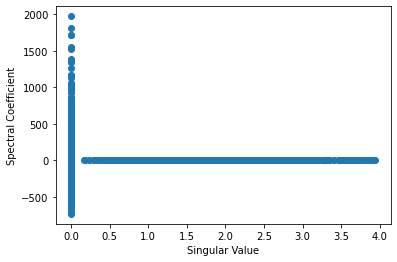

In [11]:
# RRQR spectral coefficients
pred = flow_prediction(Anaheim, {s: flows["Anaheim"][s] for s in sensors_rrqr[:90]})
plot_spectral_coefs(Anaheim, pred)

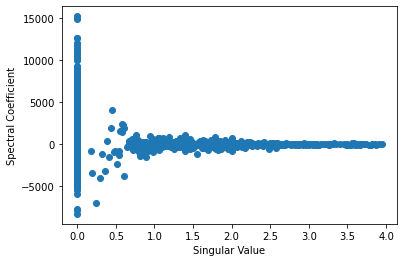

In [12]:
# True spectral coefficients
plot_spectral_coefs(Anaheim, flows["Anaheim"])

## Simple Greedy Algorithm vs Baselines

In [13]:
def err(G, sensors, labels, i):
    preds = flow_prediction(G, {s: labels[s] for s in sensors[:i]})
    return mse(preds, labels)

In [14]:
def corr(G, sensors, labels, i):
    preds = dict2vect(G, flow_prediction(G, {s: labels[s] for s in sensors[:i]}))
    actual = dict2vect(G, labels)
    return np.corrcoef(actual, preds)[1,0]

In [15]:
def get_baseline_results(G, labeled_flows, ratio, samples=50):
    k = int(G.number_of_edges() * ratio)
    
    random_sensors = choose_sensors_random(G, k=k)
    rrqr_sensors = al_flows_rrqr(G, ratio)
    rb_sensors = al_flows_rb(G, ratio)
    greedy_sensors = choose_sensors(G, labeled_flows, flow_prediction, mse, lazy=True, cores=8, k=k)
    
    greedy_corr, rand_corr, rrqr_corr, rb_corr = {}, {}, {}, {}

    for j in tqdm(range(samples)):
        i = int(k * j / samples)
        
        greedy_corr[i / G.number_of_edges()] = max(0, corr(G, greedy_sensors, labeled_flows, i))
        rand_corr[i / G.number_of_edges()] = max(0, corr(G, random_sensors, labeled_flows, i))
        rrqr_corr[i / G.number_of_edges()] = max(0, corr(G, rrqr_sensors, labeled_flows, i))
        rb_corr[i / G.number_of_edges()] = max(0, corr(G, rb_sensors, labeled_flows, i))
    
    return {
        "greedy": greedy_corr,
        "random": rand_corr,
        "rrqr": rrqr_corr,
        "rb": rb_corr
    }

In [16]:
results = {}
results["Anaheim"] = get_baseline_results(*read_tntp_graph("data/Anaheim/Anaheim_flow.tntp"), 1)

  0%|          | 0/914 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

/home/ab141/.conda/envs/sensor/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/ab141/.conda/envs/sensor/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [17]:
results["Barcelona"] = get_baseline_results(*read_tntp_graph("data/Barcelona/Barcelona_flow.tntp"), 1)

  0%|          | 0/2522 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

/home/ab141/.conda/envs/sensor/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/ab141/.conda/envs/sensor/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [18]:
results["Chicago"] = get_baseline_results(*read_tntp_graph("data/Chicago-Sketch/ChicagoSketch_flow.tntp"), 1)

  0%|          | 0/2950 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

/home/ab141/.conda/envs/sensor/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/ab141/.conda/envs/sensor/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [20]:
results["Winnipeg"] = get_baseline_results(*read_tntp_graph("data/Winnipeg/Winnipeg_flow.tntp"), 1)

  0%|          | 0/2836 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

/home/ab141/.conda/envs/sensor/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/ab141/.conda/envs/sensor/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


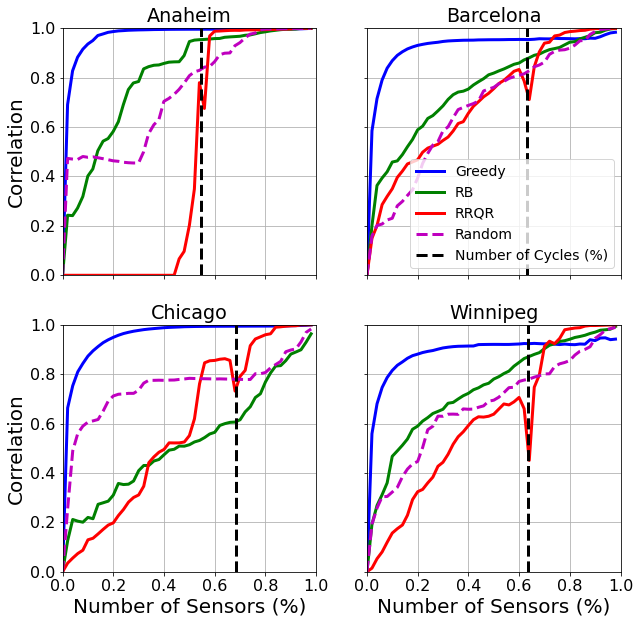

In [25]:
import matplotlib

def plot_results(G, results, ax, title, xlabel=False, ylabel=False, legend=False):
    ax.plot(results["greedy"].keys(), results["greedy"].values(), "b", label="Greedy",
           linewidth=3)
    ax.plot(results["rb"].keys(), results["rb"].values(), "g", label="RB",
           linewidth=3)
    ax.plot(results["rrqr"].keys(), results["rrqr"].values(), "r", label="RRQR",
           linewidth=3)
    ax.plot(results["random"].keys(), results["random"].values(), "m", label="Random",
           linewidth=3, linestyle="dashed")
    ax.axvline(x = (G.number_of_edges() - G.number_of_nodes() + 1) / G.number_of_edges(), c="black", 
               label="Number of Cycles (%)", linewidth=3, linestyle="dashed")
    
    if legend:
        ax.legend(fontsize=14)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    if xlabel:
        ax.set_xlabel("Number of Sensors (%)", fontsize=20)
    else:
        ax.set_xticklabels([])
    if ylabel:
        ax.set_ylabel("Correlation", fontsize=20)
    else:
        ax.set_yticklabels([])
    ax.grid("on")
    ax.set_title(title)

matplotlib.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

plot_results(Anaheim, results["Anaheim"], ax[0][0], "Anaheim", ylabel=True)
plot_results(Barcelona, results["Barcelona"], ax[0][1], "Barcelona", legend=True)
plot_results(Chicago, results["Chicago"], ax[1][0], "Chicago", xlabel=True, ylabel=True)
plot_results(Winnipeg, results["Winnipeg"], ax[1][1], "Winnipeg", xlabel=True)
plt.savefig("results/flow_correlations.pdf")

In [28]:
G = nx.house_graph()
flow = synthetic_flows(G)
get_baseline_results(G, flow, 1)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

/home/ab141/.conda/envs/sensor/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/ab141/.conda/envs/sensor/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


KeyError: (2, 0)